# 使用Mask R-CNN模型实现人体关键节点标注

在之前的[Mask R-CNN](#)案例中，我们对Mask R-CNN模型的整体架构进行简介。Mask R-CNN是一个灵活开放的框架，可以在这个基础框架的基础上进行扩展，以完成更多的人工智能任务。在本案例中，我们将展示如何对基础的Mask R-CNN进行扩展，完成人体关键节点标注的任务。

## Mask-RCNN模型的基本结构

也许您还记得我们之前介绍过的Mask R-CNN整体架构，它的3个主要网络：

- backbone网络，用于生成特征图
- RPN网络，用于生成实例的位置、分类、分割(mask)信息
- head网络，对位置、分类和分割(mask)信息进行训练

在head网络中，有分类、位置框和分割(mask)信息的3个分支，我们可以对head网络进行扩展，加入一个人体关键节点keypoint分支。并对其进行训练，使得我们的模型具备关键节点分析的能力。那么我们的模型结构将如下图所示：

![mrcnn_keypoints_overview](./img/mrcnn_keypoints_overview.jpg)

> head网络中，红色的<span style="color:red">keypionts</span>分支为新加入的**人体关键节点分支**

MaskRCNN模型的解析可以参考[此文章](https://github.com/huaweicloud/ModelArts-Lab/wiki/Mask-R-CNN%E6%A8%A1%E5%9E%8B%E8%A7%A3%E6%9E%90) 。

本案例的运行环境是 TensorFlow 1.8.0 。

## keypoints分支

在RPN中，我们生成Proposal后，当检测到Proposal的分类为"Person"时，对每个部位的关键点生成一个one-hot掩码，训练的目标最终是得到一个56*56的二值掩码，当中只有一个像素被标记为关键点，其余像素均为背景。对于每一个关键点的位置，进行最小化平均交叉熵损失检测，K个关键点是被独立处理的。

人体姿态检测中，人本身可以作为一个目标实例进行分类检测。但是，采取了one-hot编码以后，就可以扩展到coco数据集中被标注的17个人体关键点（例如：左眼、右耳），同时也能够处理非连续型数值特征。

COCO数据集中，对人体中17个关键点进行了标注，包括：鼻子,左眼,右眼,左耳,右耳,左肩,右肩,左肘,右肘,左手腕,右手腕,左膝盖,右膝盖,左脚踝,右脚踝,左小腿,右小腿，如下图所示：

![sample_keypoints](./img/sample_keypoints.png)

## 在ModelArts中训练Mask R-CNN keypoints模型

### 准备数据和源代码

第一步：准备数据集和预训练模型

In [1]:
from modelarts.session import Session
sess = Session()
sess.download_data(bucket_path='modelarts-labs-bj4/end2end/mask_rcnn_keypoints/mask_rcnn_keypoints.data.tgz',
                  path='./mask_rcnn_keypoints.data.tgz')

!tar zxf ./mask_rcnn_keypoints.data.tgz
!rm ./mask_rcnn_keypoints.data.tgz

Successfully download file modelarts-labs-bj4/end2end/mask_rcnn_keypoints/mask_rcnn_keypoints.data.tgz from OBS to local ./mask_rcnn_keypoints.data.tgz


解压后，得到data目录，其结构如下：



```bash
data/
├── mask_rcnn_coco.h5
├── annotations
│   ├── person_keypoints_train2014.json
│   ├── ***.json
├── train2014
│   ├── COCO_train2014_***.jpg
└── val2014
    ├── COCO_val2014_***.jpg
```

其中`data/mask_rcnn_coco_humanpose.h5`为预训练模型，`annotations`、`train2014`和`val2014`为我们提前准备好的最小数据集，包含了500张图片的标注信息。


第二步：准备源代码

In [2]:
sess.download_data(bucket_path='modelarts-labs-bj4/end2end/mask_rcnn_keypoints/mask_rcnn_keypoints.src.tgz',
                  path='./mask_rcnn_keypoints.src.tgz')

!tar zxf ./mask_rcnn_keypoints.src.tgz
!rm ./mask_rcnn_keypoints.src.tgz

Successfully download file modelarts-labs-bj4/end2end/mask_rcnn_keypoints/mask_rcnn_keypoints.src.tgz from OBS to local ./mask_rcnn_keypoints.src.tgz


第三步：安装依赖pycocotools

示例中，我们使用COCO数据集，需要安装工具库pycocotools

In [3]:
!pip install pycocotools

You are using pip version 9.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### 程序初始化

第一步：导入相关的库，定义全局变量

In [4]:
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# from src.mrcnn.config import Config
from src.mrcnn import coco
from src.mrcnn import utils
import src.mrcnn.model as modellib
from src.mrcnn import visualize
from src.mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = "logs"

# Local path to trained weights file
COCO_HUMANPOSE_MODEL_PATH = "data/mask_rcnn_coco_humanpose.h5"

Using TensorFlow backend.


第二步：生成配置项

我们定义Config类的子类MyTrainConfig，指定相关的参数，较为关键的参数有：


- __NAME__： Config的唯一名称
- __NUM_CLASSIS__： 分类的数量，我们只生成圆形，正方形和三角形，再加上背景，因此一共是4个分类
- __IMAGE_MIN_DIM和IMAGE_MAX_DIM__： 图片的最大和最小尺寸，我们生成固定的128x128的图片，因此都设置为128
- __TRAIN_ROIS_PER_IMAGE__： 每张图片上训练的RoI个数
- __STEPS_PER_EPOCH和VALIDATION_STEPS__： 训练和验证时，每轮的step数量，减少step的数量可以加速训练，但是检测精度降低


In [5]:
class DemoTrainConfig(coco.CocoConfig):
    # 可辨识的名称
    NAME = "demo_train"

    # GPU的数量和每个GPU处理的图片数量，可以根据实际情况进行调整，参考为Nvidia Tesla P100
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # 物体的分类个数，我们针对关键节点进行训练，只需要BG和Person两种分类
    NUM_CLASSES = 1 + 1  # background + 80 shapes

    # 图片尺寸统一处理为1024，可以根据实际情况再进一步调小
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    # 因为我们生成的形状图片较小，这里可以使用较小的Anchor进行RoI检测
#     RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # 每张图片上训练的RoI个数，可以适当调小该参数
    TRAIN_ROIS_PER_IMAGE = 100

    # 每轮训练的step数量
    STEPS_PER_EPOCH = 100

    # 每轮验证的step数量
    VALIDATION_STEPS = 20
    
config = DemoTrainConfig()
config.display()


Configurations Superlee:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  1024
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
KEYPOINT_MASK_POOL_SIZE        7
KEYPOINT_MASK_SHAPE            [56, 56]
KEYPOINT_THRESHOLD             0.005
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
LIMBS                          [0, -1, -1, 5, -1, 6, 5, 7, 6, 8, 7, 9, 8, 10, 11, 13, 12, 14, 13, 15, 14, 16]
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               128
MEAN_PIXEL                 

第三步：创建数据集对象

我们使用封装好的CocoDataset类，生成训练集和验证集。

In [6]:
from src.mrcnn.coco import CocoDataset
COCO_DIR = 'data'

# 生成训练集
dataset_train = CocoDataset(task_type="person_keypoints")
dataset_train.load_coco(COCO_DIR, "train", "2014") #　加载训练数据集
dataset_train.prepare()


# 生成验证集
dataset_val = CocoDataset(task_type="person_keypoints")
dataset_val.load_coco(COCO_DIR, "val", "2014") #　加载验证数据集
dataset_val.prepare()


# 打印数据集中keypoints的相关信息
print("Train Keypoints Image Count: {}".format(len(dataset_train.image_ids)))
print("Train Keypoints Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))

print("Val Keypoints Image Count: {}".format(len(dataset_val.image_ids)))
print("Val Keypoints Class Count: {}".format(dataset_val.num_classes))
for i, info in enumerate(dataset_val.class_info):
    print("{:3}. {:50}".format(i, info['name']))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Skeleton: (19, 2)
Keypoint names: (17,)
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Skeleton: (19, 2)
Keypoint names: (17,)
Train Keypoints Image Count: 275
Train Keypoints Class Count: 2
  0. BG                                                
  1. person                                            
Val Keypoints Image Count: 262
Val Keypoints Class Count: 2
  0. BG                                                
  1. person                                            


## 创建模型

用"training"模式创建模型对象，并加载预训练模型

In [7]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
# model.load_weights(COCO_MODEL_PATH, by_name=True,exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
#                                 "mrcnn_bbox", "mrcnn_mask"])

COCO_HUMANPOSE_MODEL_PATH = './data/mask_rcnn_coco_humanpose.h5'
# Load weights trained on MS-COCO
print("Loading weights from ", COCO_HUMANPOSE_MODEL_PATH)

model.load_weights(COCO_HUMANPOSE_MODEL_PATH, by_name=True)

# model.keras_model.summary()

Loading weights from  ./data/mask_rcnn_coco_humanpose.h5


## 训练模型

Keras中的模型可以按照制定的层进行构建，在模型的train方法中，我们可以通过layers参数来指定特定的层进行训练。layers参数有以下几种预设值：

- heads:只训练head网络中的分类、mask和bbox回归
- all: 所有的layer
- 3+: 训练ResNet Stage3和后续Stage
- 4+: 训练ResNet Stage4和后续Stage
- 5+: 训练ResNet Stage5和后续Stage

此外，layers参数还支持正则表达式，按照匹配规则指定layer，可以调用model.keras_model.summary()查看各个层的名称，然后按照需要指定要训练的层。

我们针对不同的layer进行训练，首先，训练head网络中的4个分支：

In [8]:
# Training - Stage 1
print("Train heads")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=1,
            layers='heads')

Train heads


Instructions for updating:
keep_dims is deprecated, use keepdims instead



Starting at epoch 0. LR=0.002

Checkpoint Path: logs/demo_train20191202T1924/mask_rcnn_demo_train_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_keypoint_mask_conv1   (TimeDistributed)
mrcnn_keypoint_mask_bn1   (TimeDistributed)
mrcnn_keypoint_mask_conv2   (TimeDistributed)
mrcnn_keypoint_mask_bn2   (TimeDistributed)
mrcnn_keypoint_mask_conv3   (TimeDistributed)
mrcnn_keypoint_mask_bn3   (TimeDistributed)
mrcnn_keypoint_mask_conv4   (TimeDistributed)
mrcnn_keypoint_mask_bn4   (TimeDistributed)
mrcnn_keypoint_mask_conv5   (TimeDistributed)
mrcnn_keypoint_mask_bn5   (TimeDistributed)
mrcnn_keypoint_mask_conv6

/home/ma-user/anaconda3/envs/TensorFlow-1.8/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ma-user/anaconda3/envs/TensorFlow-1.8/lib/python3.6/site-packages/keras/engine/training_generator.py:44: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
/home/ma-user/anaconda3/envs/TensorFlow-1.8/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Epoch 1/1


/home/ma-user/anaconda3/envs/TensorFlow-1.8/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


100/100 [==============================] - 44s 443ms/step - loss: 5.2100 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2354 - mrcnn_class_loss: 0.0788 - mrcnn_bbox_loss: 0.1457 - keypoint_mrcnn_mask_loss: 4.5105 - mrcnn_mask_loss: 0.2319 - val_loss: 6.1276 - val_rpn_class_loss: 0.0012 - val_rpn_bbox_loss: 0.1010 - val_mrcnn_class_loss: 0.0668 - val_mrcnn_bbox_loss: 0.1235 - val_keypoint_mrcnn_mask_loss: 5.6883 - val_mrcnn_mask_loss: 0.1468


然后训练ResNet Stage4和后续Stage

In [9]:
# Training - Stage 2
# Finetune layers from ResNet stage 4 and up


# print("Training Resnet layer 4+")
# model.train(dataset_train, dataset_val,
#             learning_rate=config.LEARNING_RATE / 10,
#             epochs=1,
#             layers='4+')

最后，对所有layer进行优化，并将训练的模型保存到本地

In [10]:
# Training - Stage 3
# Finetune layers from ResNet stage 3 and up
print("Training Resnet layer 3+")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 100,
            epochs=2,
            layers='all')


model_savepath = 'demo_mrcnn_humanpose_model.h5'
model.keras_model.save_weights(model_savepath)

Training Resnet layer 3+

Starting at epoch 1. LR=2e-05

Checkpoint Path: logs/demo_train20191202T1924/mask_rcnn_demo_train_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)

/home/ma-user/anaconda3/envs/TensorFlow-1.8/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ma-user/anaconda3/envs/TensorFlow-1.8/lib/python3.6/site-packages/keras/engine/training_generator.py:44: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


## 使用模型检测图片物体

第一步：创建"Inference"模式的模型对象，并加载我们训练好的模型文件

In [11]:
# Recreate the model in inference mode
inference_model = modellib.MaskRCNN(mode="inference", 
                          config=config,
                          model_dir=MODEL_DIR)

# 加载我们自己训练出的形状模型文件的权重信息
print("Loading weights from ", model_savepath)
inference_model.load_weights(model_savepath, by_name=True)

Loading weights from  demo_mrcnn_humanpose_model.h5


第二步：从验证数据集中随机选出一张图片，显式Ground Truth信息

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
image_meta               shape: (10,)                 min:    0.00000  max: 1024.00000
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000
gt_bbox                  shape: (1, 4)                min:   16.00000  max: 1014.00000
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000


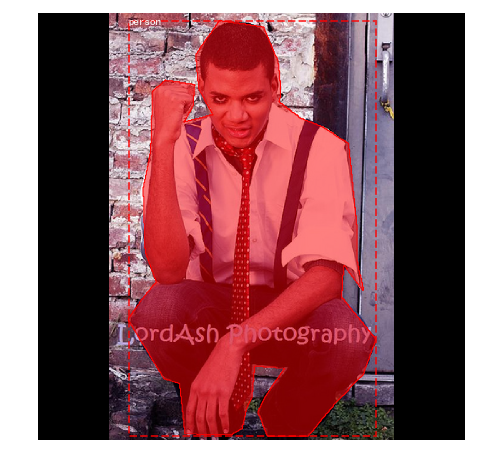

In [12]:
# 随机选出图片进行测试
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

第三步：使用模型对图片进行预测，并显示结果

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000
windows                  shape: (1, 4)                min:    0.00000  max: 1024.00000
rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000
rpn_bbox                 shape: (1, 261888, 4)        min:   -9.28299  max:  176.56233
rois                     shape: (1, 1000, 4)          min:    0.00000  max:    1.00000
mrcnn_class              shape: (1, 1000, 2)          min:    0.00000  max:    1.00000
mrcnn_bbox               shape: (1, 1000, 2, 4)       min:   -4.40554  max:    3.96543
detections               shape: (1, 100, 6)           min:    0.00000  max: 1024.00000
mrcnn_mask               shape: (1, 100, 28, 28, 2)   min:    0.00003  max:    0.99982
mrcnn_keypoint_prob    

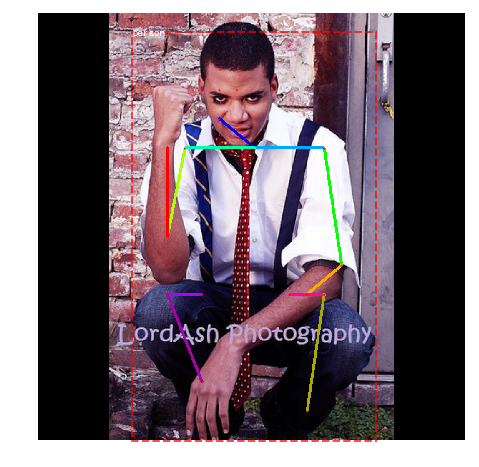

In [13]:
results = inference_model.detect_keypoint([original_image], verbose=1)
r = results[0] # for one image
log("rois",r['rois'])
log("keypoints",r['keypoints'])
log("class_ids",r['class_ids'])
log("keypoints",r['keypoints'])
log("masks",r['masks'])
log("scores",r['scores'])

# 定义助手函数用于设置matplot中的子绘制区域所在的行和列
def get_ax(rows=1, cols=1, size=8):
    
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

visualize.display_keypoints(original_image, r['rois'], r['keypoints'], r['class_ids'],
                            dataset_train.class_names,skeleton=config.LIMBS, ax=get_ax())

## 小结

此案例基于`Mask RCNN`模型，识别人体的关键点。